In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import pandas as pd

import seaborn
seaborn.set_context("talk")

In [2]:
from dacbench.benchmarks import LubyBenchmark, SigmoidBenchmark
from dacbench.wrappers import PerformanceTrackingWrapper, RewardNoiseWrapper
from dacbench.logger import Logger, load_logs, log2dataframe
from dacbench.plotting import plot_performance, plot_performance_per_instance

# First steps: running an episode

### Creating a benchmark object
Benchmarks are environments created by a benchmark object.
First, we take a look at that object and the configuration it holds:

In [3]:
bench = LubyBenchmark()
for k in bench.config.keys():
    print(f"{k}: {bench.config[k]}")

config_space: Configuration space object:
  Hyperparameters:
    sequence_element, Type: UniformInteger, Range: [0, 6], Default: 3

observation_space_class: Box
observation_space_type: <class 'numpy.float32'>
observation_space_args: [array([-1, -1, -1, -1, -1, -1]), array([128., 128., 128., 128., 128., 128.])]
reward_range: (-1, 0)
cutoff: 64
hist_length: 5
min_steps: 8
seed: 0
instance_set_path: ../instance_sets/luby/luby_default.csv
benchmark_info: {'identifier': 'Luby', 'name': 'Luby Sequence Approximation', 'reward': 'Boolean sucess indication', 'state_description': ['Action t-2', 'Step t-2', 'Action t-1', 'Step t-1', 'Action t (current)', 'Step t (current)']}


### Getting the benchmark environment
Now we can either get the default benchmark setting like this:

In [4]:
env = bench.get_benchmark(seed=1)

Or first modify the the benchmark, e.g. by setting a different seed.
In that case, we use the get_environment() method to explicitly override the defaults.

In [5]:
bench.config.seed = 9
env = bench.get_environment()

To then save our modification as a config file to share with others, run:

In [6]:
bench.save_config("test_config.json")

We can also load an existing benchmark configuration (e.g. from our challenge benchmarks):

In [7]:
bench = LubyBenchmark("dacbench/challenge_benchmarks/reward_quality_challenge/level_1/luby.json")
env = bench.get_environment()

### Running the benchmark
To execute a run, first reset the environment. It will return an initial state as well as a dictonary that may or may not contain some meta-information:

In [8]:
state, info = env.reset()
print(state)
print(info)

[-1 -1 -1 -1 -1 -1]
{}


Then we can run steps until the algorithm run is done:

In [10]:
terminated, truncated = False, False
cum_reward = 0
while not (terminated or truncated):
    state, reward, terminated, truncated, info = env.step(1)
    cum_reward += reward
print(f"Episode 1/1...........................................Reward: {cum_reward}")

Episode 1/1...........................................Reward: -1


# A more complex example: multiple seeds & logging

### Creating env and logger object
Using a Logger object, we can track the performance on the environment over time.
To make the benchmark more difficult, we use a wrapper to add noise to the reward signal.

In [11]:
# Automatically setting up env and logger
def setup_env(seed):
    # Get benchmark env
    bench = SigmoidBenchmark()
    env = bench.get_benchmark(seed=seed)
    
    # Make logger to write results to file
    logger = Logger(experiment_name=f"Sigmoid_s{seed}", output_path=Path("example"))
    perf_logger = logger.add_module(PerformanceTrackingWrapper)
    
    # Wrap the environment to add noise and track the reward
    env = RewardNoiseWrapper(env, noise_dist="normal", dist_args=[0, 0.3])
    env = PerformanceTrackingWrapper(env, logger=perf_logger)
    logger.set_env(env)
    logger.set_additional_info(seed=seed)
    
    return env, logger

Now we run the environment on 5 different seeds, logging the results of each one.
In this example, we use a simple random agent.

In [15]:
from dacbench.agents import RandomAgent
from dacbench.runner import run_benchmark

for seed in [0, 1, 2, 3, 4]:
    env, logger = setup_env(seed)
    
    # This could be any optimization or learning method
    agent = RandomAgent(env)
    run_benchmark(env, agent, num_episodes=10, logger=logger)

After we're done training, we can load the results into a pandas DataFrame for further inspection

In [16]:
results = []
for seed in [0, 1, 2, 3, 4]:
    logs = load_logs(f"example/Sigmoid_s{seed}/PerformanceTrackingWrapper.jsonl")
    results.append(log2dataframe(logs, wide=True))
results = pd.concat(results)

DACBench includes plotting functionality for commonly used plots like performance over time:

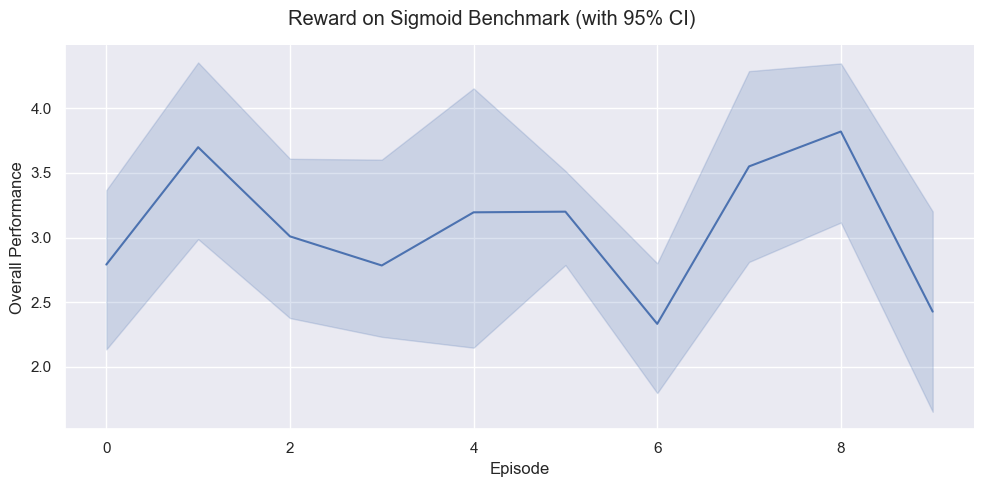

In [17]:
# Plot performance over time
plot = plot_performance(results, title="Reward on Sigmoid Benchmark (with 95% CI)", aspect=2)

This plot can also be split into the different seeded runs:

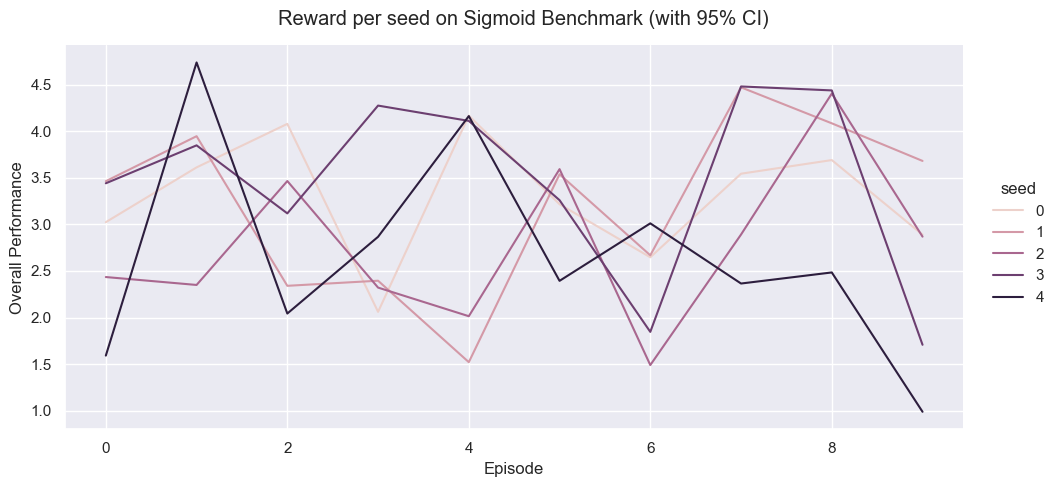

In [18]:
plot = plot_performance(results, title="Reward per seed on Sigmoid Benchmark (with 95% CI)", hue="seed", aspect=2)

And as we're training on an instance set, we can also see how the mean performance per instance looks:

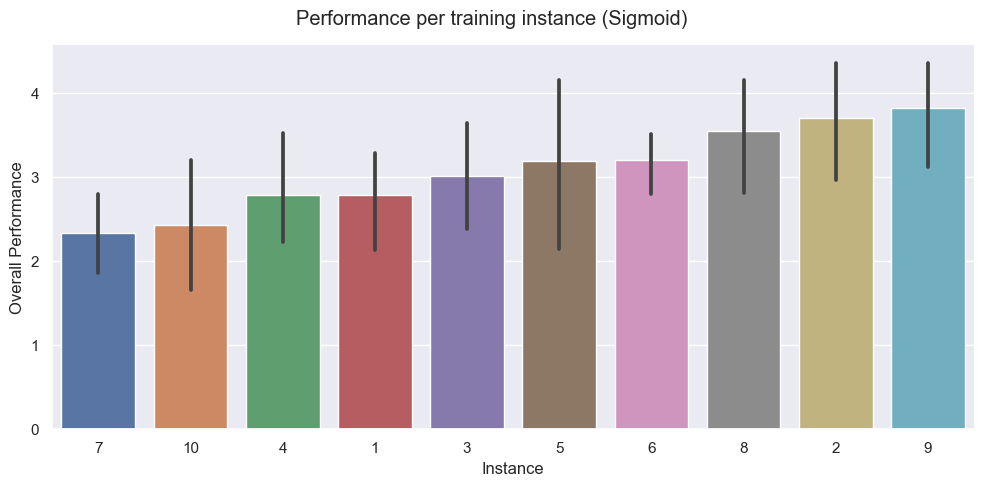

In [19]:
plot_performance_per_instance(results, title="Performance per training instance (Sigmoid)", aspect=2)